<div class="header">
    <div class="title">
    <h1>Programming Exercise 2</h1>
    </div>
    <div class="authors">
        Prof. Dr. Julia Kowalski<br/>
        Ullika Scholz <br/>
        Ingo Steldermann <br/>
    </div>
    <div class="logo">
        <img src="https://www.mbd.rwth-aachen.de/global/show_picture.asp?id=aaaaaaaabkcpost">
        This content is best viewed in JupyterLab.
    </div>
</div>

# Task

The main task of this exercise will be work with the mapping between the physical and reference coordinates. In order to complete the first part of the exercise, you will therefore implement routines to construct the stiffness matrix and the right hand side in
- setEquationSystem

and apply appropriate boundary conditions in a second step in
- setBoundaryConditions

The second part will contain a small convergence study under mesh refinement.
The third part illustrates of the effects of different parameter sets. You will not need to code anything in this part.

Part four and five are optional tasks. You wil explore higher order methods and other element geometries. 

<div class="alert alert-danger alert-block">
        The main structure of the code is already set up. You only need to add code at places with a '#TODO'comment.
</div>

**Feel free to ask any questions (steldermann@mbd.rwth-aachen.de), if you have problems to get your code running.**

# Imports

In [44]:
from lwmeshutils import MeshUtilities, unit_triangle_quadrature, unit_interval_quadrature
from scipy.sparse import spdiags, csc_matrix
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Major Plot settings for testing
% matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Setup

Consider the slightly generalized problem from the exercise sheet
$$ 
\begin{aligned}
    - c \, \Delta u &= f &&\text{in} \,\, \Omega \\
      u &= d &&\text{on} \,\, \Gamma_D \\
     \partial_n u &= n && \text{on} \,\, \Gamma_N
\end{aligned}
$$
where $c, d, n \in \mathbb{R}$ are constants and $f: \mathbb{R}^2 \rightarrow \mathbb{R}$ is a function mapping the coordinates (x,y) to some function value.

The dictionary returned by `parameters()` will hold all essential parameters of our problem. In particular, you will be able to change
- the source term $f$ via 'sourceFunc' (lambda function)
- the lapace coefficient $c$ via 'lapalceCoeff'
- the neumann coefficient $d$ via 'neumannCoeff'
- the dirichlet value $d$ via 'dirichletValue'
- the order of the element basis via 'order'

In [45]:
def parameters(sourceFunc=(lambda x,y: 1.0), laplaceCoeff=1.0, neumannCoeff=0.0, dirichletValue=0.0, order=1):
    params = {}
    params["sourceFunc"] = sourceFunc
    params["laplaceCoeff"] = laplaceCoeff
    params["neumannCoeff"] = neumannCoeff
    params["dirichletValue"] = dirichletValue
    params["order"] = order
    return params

# let's use the function above to generate all parameter sets we need this exercise.
paramConst = parameters()
paramSin = parameters(sourceFunc=(lambda x,y: np.sin(2*np.pi*x)))
paramConstDir = parameters(dirichletValue=1.0)
paramConst2Order = parameters(order=2)

In [46]:
class SimpleLogger:
    def print(fDebug: bool, *args, **kwargs):
        if fDebug:
            print(*args, **kwargs)

In [47]:
def get_error(mesh_ops: MeshUtilities, u: np.ndarray, params: dict):
    error = Decimal(mesh_ops.find_L2_error_via_fourier(u, params["order"])[0])
    print(
        "num elements:",
        mesh_ops.get_triangle_count(),
        "---",
        "L2 error:",
        "%.2E" % error
    )
    return float(error)
    

## `setEquationSystem`

In [48]:
def setEquationSystem(meshdata: MeshUtilities, param: dict, fDebug: bool = False): 
    rhsGlob = param["sourceFunc"]
    A = np.zeros((meshdata.get_node_count(), meshdata.get_node_count()))
    f = np.zeros(((meshdata.get_node_count(),1)))

    # contribution of the triangles to the stiffness matrix
    quadLocation, quadWeight, quadCount = unit_triangle_quadrature()
    for iTria in range(meshdata.get_triangle_count()):
        if (param["order"] == 1):
            Ae = np.zeros((3,3))
            fe = np.zeros((3,1))
        elif (param["order"] == 2):
            Ae = np.zeros((6,6))
            fe = np.zeros((6,1))

        for iQuad in range(quadCount):
            # stiffness matrix triangles
            dN_xi = meshdata.get_triangle_form_function_derivative(param["order"], quadLocation[iQuad])
            tmp = np.matmul(meshdata.triangle_inverse_jacobian_T(iTria), dN_xi.T)
            tmpTriangle = np.matmul(tmp.T, tmp)
            Ae += quadWeight[iQuad] * tmpTriangle * meshdata.triangle_jacobian_determinant(iTria)
        

            # rhs triangles contribution
            N = meshdata.get_triangle_form_function(param["order"], quadLocation[iQuad])
            natural_point = meshdata.calc_triangle_integration_point(iTria, quadLocation[iQuad])
            rhsLoc = rhsGlob(
                natural_point[0],
                natural_point[1]
            )
            rhsLocScal = N * rhsLoc
            fe += quadWeight[iQuad] * rhsLocScal * meshdata.triangle_jacobian_determinant(iTria)
        
        # push to global A
        # check that the loop is in the right order
        SimpleLogger.print(fDebug, "Element Matrix:\n", Ae)
        SimpleLogger.print(fDebug, meshdata.get_triangle_nodes(iTria, param["order"]))
        for iRef,iReal in enumerate(meshdata.get_triangle_nodes(iTria, param["order"])):
            f[iReal] += fe[iRef]
            for jRef, jReal in enumerate(meshdata.get_triangle_nodes(iTria, param["order"])):
                A[iReal, jReal] += Ae[iRef, jRef]
        SimpleLogger.print(fDebug, "Global Matrix:\n", A)
    return param["laplaceCoeff"]*A, f

## `setBoundaryValues`

In [49]:
def setBoundaryValues(meshOps: MeshUtilities, param: dict, A, f): 
    """
    Dirichlet boundary means that some solutions are known up-front.
    Solutions are available exactly on the \Gamma_{D}
    """
    lines = meshOps.mesh.lines[
        np.where([
            line.any() for line in meshOps.mesh.lines
        ])
    ]
    quadLocation, quadWeight, quadCount = unit_interval_quadrature()
    
    for line_idx in range(len(lines)):
        # Apply Dirichlet BC
        if(lines[line_idx][2] == 2):
            for node_idx in lines[line_idx][0:2]:
                A[node_idx] = np.array([1 if i == node_idx else 0 for i in range(len(A[node_idx]))])
                f[node_idx] = param["dirichletValue"]
        
        # Apply Neumann BC
        if(lines[line_idx][2] == 3):
            A_n = np.zeros((2, 2))
            
            for iQuad in range(quadCount):
                N_xi = meshOps.get_line_form_function(
                    param["order"], quadLocation[iQuad]
                )
                
                tmp = np.matmul(N_xi, meshOps.line_jacobian(line_idx))

                A_n += quadWeight[iQuad]* \
                    meshOps.line_jacobian_determinant(line_idx)* \
                    param["neumannCoeff"]* \
                    tmp
            
            for iRef, iReal in enumerate(lines[line_idx][0:2]):
                for jRef, jReal in enumerate(lines[line_idx][0:2]):
                    A[iReal, jReal] -= A_n[iRef, jRef]
                    
    return A, f

# Part 1: Unit Square
This is essentially the evaluation of subtask 1. and the verification part of subtask 2. from the exercise sheet:

In [50]:
# set up the problem on unitSquare1
meshOps = MeshUtilities('mesh/unitSquare1.msh')

In [146]:
paramSetting = paramConst

A,f = setEquationSystem(meshOps, paramSetting)
SimpleLogger.print(False, "After setEqSystem:")
SimpleLogger.print(False, A)
SimpleLogger.print(False, f)
SimpleLogger.print(False, "---")
A,f = setBoundaryValues(meshOps, paramSetting, A, f)
SimpleLogger.print(False, "After setBoundaryValues")
SimpleLogger.print(True, A)
SimpleLogger.print(False, f)
SimpleLogger.print(False, "---")
SimpleLogger.print(False, "Solution vector u")
u = np.linalg.solve(A, f)
SimpleLogger.print(False, u[0:5])

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [-1. -1. -1. -1.  4.]]


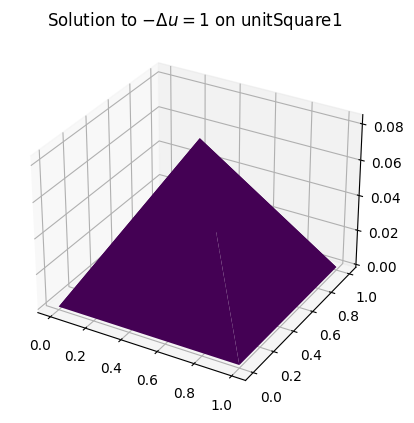

In [147]:
# Plot solution
fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
ax.set_title("Solution to $-\Delta u = 1$ on unitSquare1")
meshOps.plot(ax, u)

### Evaluate L2 error

In [148]:
get_error(meshOps, u, paramSetting)

num elements: 4 --- L2 error: 3.89E-02


0.03890498422712052

## 1.(b)

Number of nodes where Neumann conditions will be enforced: 17
num elements: 1024 --- L2 error: 1.93E-04


0.00019305377370885368

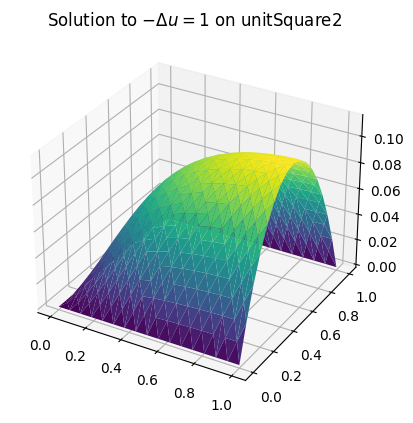

In [149]:
meshOps = MeshUtilities("mesh/unitSquare2.msh")

n_neumann_nodes = len(
    list(
        filter(
            lambda x: meshOps.get_line_tag(x) == 3, range(meshOps.get_line_count())
        )
    )
) + 1
print(
    "Number of nodes where Neumann conditions will be enforced: " 
    f"{n_neumann_nodes}"
)

A,f = setEquationSystem(meshOps, paramConst)
A,f = setBoundaryValues(meshOps, paramConst, A,f)
u = np.linalg.solve(A,f)

fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
meshOps.plot(ax, u)
ax.set_title("Solution to $-\Delta u = 1$ on unitSquare2")

get_error(meshOps, u, paramConst)

## 1.(c)

num elements: 1024 --- L2 error: 8.35E-02


Text(0.5, 0.92, 'Solution to $-\\Delta u = \\sin 2\\pi x$ on unitSquare2')

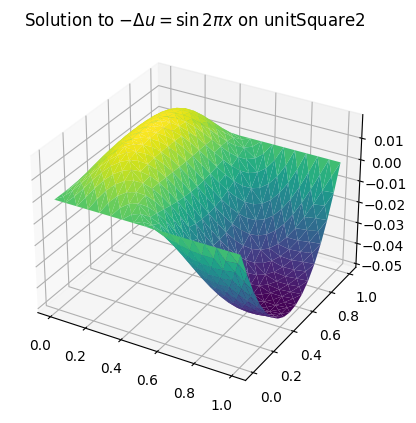

In [150]:
meshOps = MeshUtilities("mesh/unitSquare2.msh")
A,f = setEquationSystem(meshOps, paramSin)
A,f = setBoundaryValues(meshOps, paramSin, A, f)
u = np.linalg.solve(A, f)

get_error(meshOps, u, paramSin)

fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
meshOps.plot(ax, u)
ax.set_title("Solution to $-\Delta u = \sin 2\pi x$ on unitSquare2")

# Part 2: Error Evaluation

Now, we want to investigate the convergence order under grid refinement.
This time, you should implement your own small error evaluation and create a plot of the result. Use the meshes 'mesh64.msh', 'mesh256.msh' and 'mesh1024.msh' with an appropriate set of parameters.
Why must $f(x,y)=1$ to obtain the theoretical convergence rate from the lecture?

In [63]:
def get_refinement_error(params: dict) -> np.ndarray:
        mesh_data = ["mesh/mesh64.msh", "mesh/mesh256.msh", "mesh/mesh1024.msh"]
        error_infos = []
        for mesh in mesh_data:
            error_info = []
            
            meshOps = MeshUtilities(mesh)
            error_info.append(meshOps.get_triangle_count())

            A,f = setEquationSystem(meshOps, params)
            A,f = setBoundaryValues(meshOps, params, A, f)
            u = np.linalg.solve(A, f)
            
            error_info.append(
                get_error(meshOps, u, params)
            )
            error_infos.append(error_info)
        return np.array(error_infos)

def plot_refinement_error(n_elements: list, error_value: list):
    plt.title("Error evaluation under refinement")
    plt.xlabel("n elements")
    plt.ylabel("error value")
    plt.plot(n, error_infos[1], 'x-')

num elements: 64 --- L2 error: 3.00E-03
num elements: 256 --- L2 error: 7.68E-04
num elements: 1024 --- L2 error: 1.93E-04


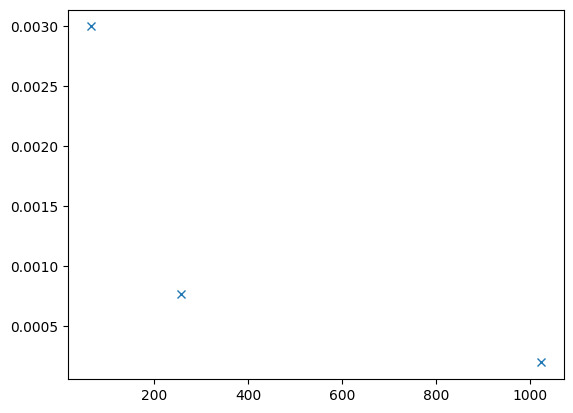

In [57]:
error_infos = get_refinement_error(parameters()).T

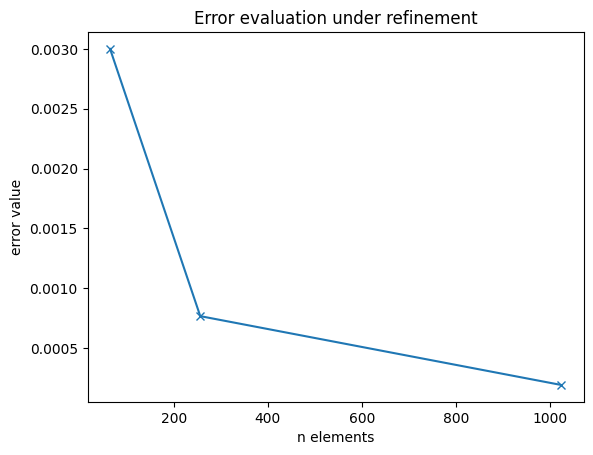

# Part 3: Investigate behavior of different parameter sets

If you have successfully implemented the above exercise, we can now study how the parameters effect the solution of our problem

## Generate data

In [168]:
meshOps = MeshUtilities('mesh/mesh1024.msh')

paramConstLaplace = [
    parameters(laplaceCoeff=1.0), 
    parameters(laplaceCoeff=10.0), 
    parameters(laplaceCoeff=100.0)
]

paramConstNeumann = [
    parameters(neumannCoeff=0.0), 
    parameters(neumannCoeff=100.0), 
    parameters(neumannCoeff=-50.0)
]

paramConstDirichlet = [
    parameters(dirichletValue=0.0),
    parameters(dirichletValue=1.0),
    parameters(dirichletValue=2.0)
]

paramSourceFunction = [
    parameters(sourceFunc=(lambda x,y: np.sin(2*np.pi*x))),
    parameters(sourceFunc=(lambda x,y: np.sin(4.4*np.pi*x))),
    parameters(sourceFunc=(lambda x,y: np.sin(7*np.pi*x)))
]

Next, we build and compute our solution for each set of testcases:

## Compute Solutions

In [169]:
paramList = [
    paramConstLaplace,
    paramConstNeumann, 
    paramConstDirichlet,
    paramSourceFunction
]

solutionList = []

#Compute solutions
for paramType in paramList:
    for param in paramType:
        A, f = setEquationSystem(meshOps, param)
        A, f = setBoundaryValues(meshOps, param, A, f)
        u = np.linalg.solve(A, f)
        solutionList.append(u)

## Reshape Data

In [170]:
solutionList = np.array(solutionList)
#reformat so it can be plotted easily
paramList = np.array(paramList).reshape((4,3))
solutionList =  solutionList.reshape((4,3, solutionList.shape[1]))

## Plot Data

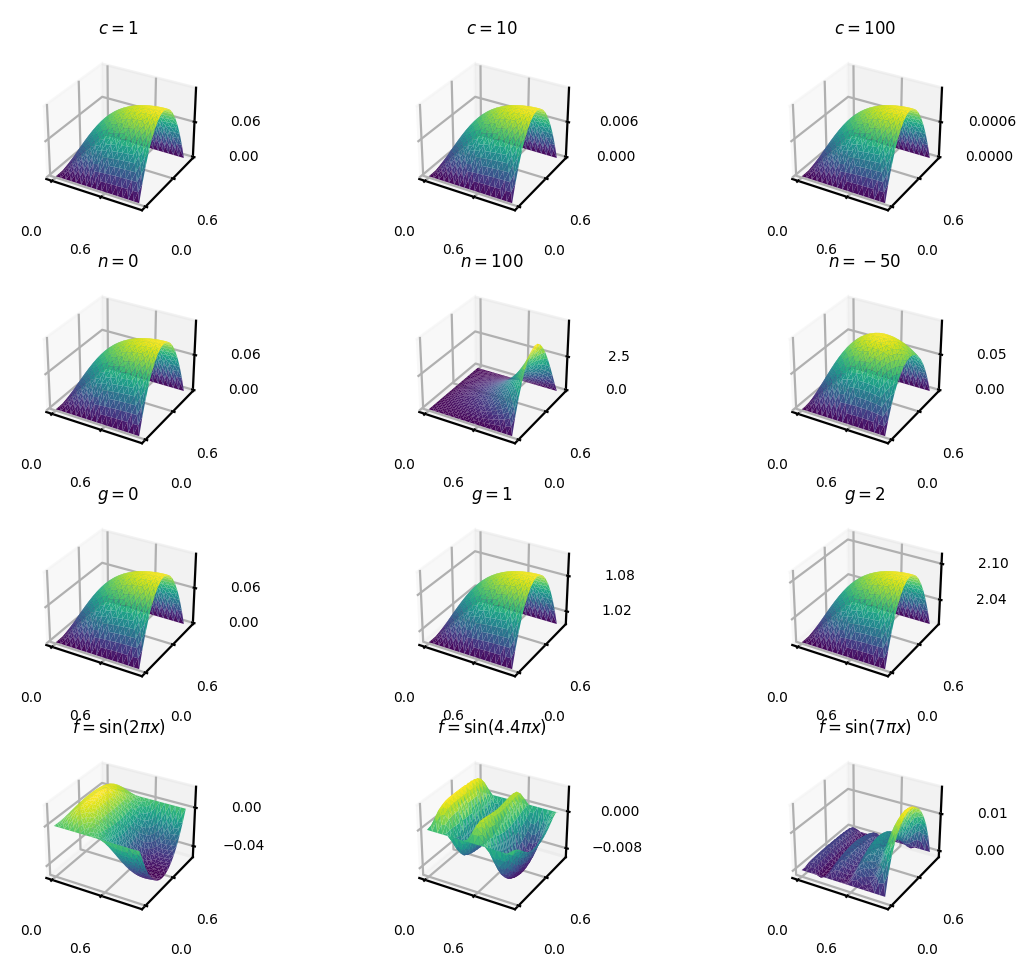

In [172]:
fig = plt.figure()
fig.set_dpi(200)

for i in np.arange(0, 4):
    for j in np.arange(0,3):
        ax = fig.add_subplot(4,3,3*i+j+1, projection='3d')
        meshOps.plot(ax, solutionList[i,j,:])
        ax.tick_params(axis='both', which='major', labelsize=5)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(2)) 
        ax.yaxis.set_major_locator(ticker.MaxNLocator(2)) 
        ax.zaxis.set_major_locator(ticker.MaxNLocator(2)) 
        
fig.axes[0].set_title('$c = 1$', fontsize=6)
fig.axes[1].set_title('$c = 10$', fontsize=6)
fig.axes[2].set_title('$c = 100$', fontsize=6)
fig.axes[3].set_title('$n = 0$', fontsize=6)
fig.axes[4].set_title('$n = 100$', fontsize=6)
fig.axes[5].set_title('$n = -50$', fontsize=6)
fig.axes[6].set_title('$g = 0$', fontsize=6)
fig.axes[7].set_title('$g = 1$', fontsize=6)
fig.axes[8].set_title('$g = 2$', fontsize=6)
fig.axes[9].set_title('$f = \sin(2 \pi x)$', fontsize=6)
fig.axes[10].set_title('$f = \sin(4.4 \pi x)$', fontsize=6)
fig.axes[11].set_title('$f = \sin(7 \pi x)$', fontsize=6)
        
    
plt.tight_layout()
plt.show()

# Part 4: Higher Order Methods

If you want to implement higher order methods, we suggest to start with second order triangular meshes, since a sample mesh already exists.

## Compute 2nd order case

Here are some reference results for $A[0:7, 0:7]$, $f[0:7]$ and $u[0:7]$. Your own results might differ slightly due to numerical inaccuracies.

**After setEqSystem**

$$
A = \left(\begin{array}{ccccccc} 
0.83755438 & 0. & 0. & 0. & 0. & 0. & 0.        \\
0. & 0.83772945 & 0. & 0. & 0.08882995 & 0. & 0.        \\
0. & 0. & 0.83718431 & 0. & 0. & 0. & 0.08829373 \\
0. & 0. & 0. & 0.83748811 & 0. & 0. & 0.        \\
0. & 0.08882995 & 0. & 0. & 1.79224013 & 0.0518264 & 0.        \\
0. & 0. & 0. & 0. & 0.0518264 & 1.79986589 & 0.05147507 \\
0. & 0. & 0.08829373 & 0. & 0. & 0.05147507 & 1.79186399
\end{array}\right)
$$

$$
f =\left(\begin{array}{c} 
-8.13151629e-19 &
-1.84314369e-18 & 
-5.42101086e-19 & 
-1.73472348e-18 & 
-2.24971951e-18 & 
-1.84314369e-18 & 
-2.14129929e-18 
\end{array}\right)^T
$$

**After setBoundaryValues**

$$
A = \left(\begin{array}{ccccccc} 
1. & 0. & 0. & 0. & 0. & 0. & 0.        \\
0. & 1. & 0. & 0. & 0. & 0. & 0.        \\
0. & 0. & 1. & 0. & 0. & 0. & 0.        \\
0. & 0. & 0. & 1. & 0. & 0. & 0.        \\
0. & 0.08882995 & 0. & 0. & 1.79224013 & 0.0518264 & 0.        \\
0. & 0. & 0. & 0. & 0.0518264 & 1.79986589 & 0.05147507\\
0. & 0. & 0.08829373 & 0. & 0. & 0.05147507 & 1.79186399
\end{array}\right)
$$

$$
f=\left(\begin{array}{c} 
 0.00000000e+00 & 
 0.00000000e+00 & 
 0.00000000e+00 & 
 0.00000000e+00 & 
-2.24971951e-18 & 
-1.84314369e-18 & 
-2.14129929e-18
\end{array}\right)^T
$$

**Solution** 

$$
u = \left(\begin{array}{ccccccc} 
 3.46157019e-30 &
 0.00000000e+00 &
-5.34762849e-19 &
 1.75859624e-18 &
 5.18385722e-03 &
 8.90043718e-03 &
 1.15770075e-02 
\end{array}\right)^T
$$

In [ ]:
meshOps_2nd = MeshUtilities('mesh/unitSquare2ndOrder.msh')

In [ ]:
A,f = setEquationSystem(meshOps_2nd,paramConst2Order)
print("After setEqSystem:")
print(A[0:7, 0:7])
print(f[0:7])
print("---")

A,f = setBoundaryValues(meshOps_2nd,paramConst2Order,A,f)
print("After setBoundaryValues")
print(A[0:7, 0:7])
print(f[0:7])
print("---")

print("Solution vector u")
u_2nd = np.linalg.solve(A,f)
print(u[0:7])

## Compute 1st order case

In [ ]:
meshOps_1st = MeshUtilities('mesh/mesh64.msh')

In [ ]:
A,f = setEquationSystem(meshOps_1st,paramConst)
A,f = setBoundaryValues(meshOps_1st,paramConst, A,f)
u_1st = np.linalg.solve(A,f)

## Plotting

In [ ]:
fig = plt.figure()
fig.tight_layout()
#fig.set_dpi(200)

ax = fig.add_subplot(1,2,1, projection='3d')
meshOps_1st.plot(ax, u_1st)
ax = fig.add_subplot(1,2,2, projection='3d')
meshOps_2nd.plot(ax, u_2nd)
fig.axes[0].set_title('using $P_1$ elements')
_ = fig.axes[1].set_title('using $P_2$ elements')

# Part 5: Beyond Triangular Meshes

If you want to go beyond triangular meshes, you will need to carefully adapt the file 'MeshOperations.py'. Only the 
- load_gmsh(...)

function is complete. You also need to generate an appropriate mesh. 
You may want to the following two resources
- http://www.manpagez.com/info/gmsh/gmsh-2.2.6/gmsh_63.php
- https://gmsh.info/doc/texinfo/gmsh.html#MSH-file-format

as well as have a look at the provided triangular meshes.

In [ ]:
# TODO